In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [2]:
# Data agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

Make CNN for MNIST handwritten digit recognition

In [3]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [4]:
# Load the MNIST dataset
trainDataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
testDataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False)


torch.Size([28, 28])

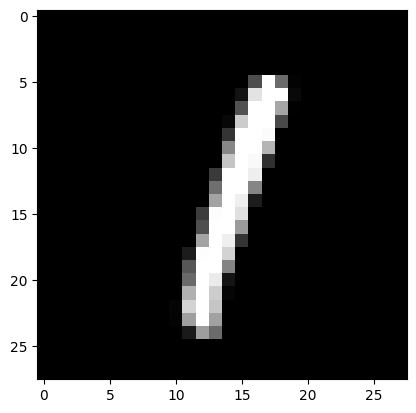

In [5]:
randInd = torch.randint(0,10,(1,))
image, label = testDataset[randInd.item()]
plt.imshow(image.squeeze(), cmap='gray')

image.squeeze().shape

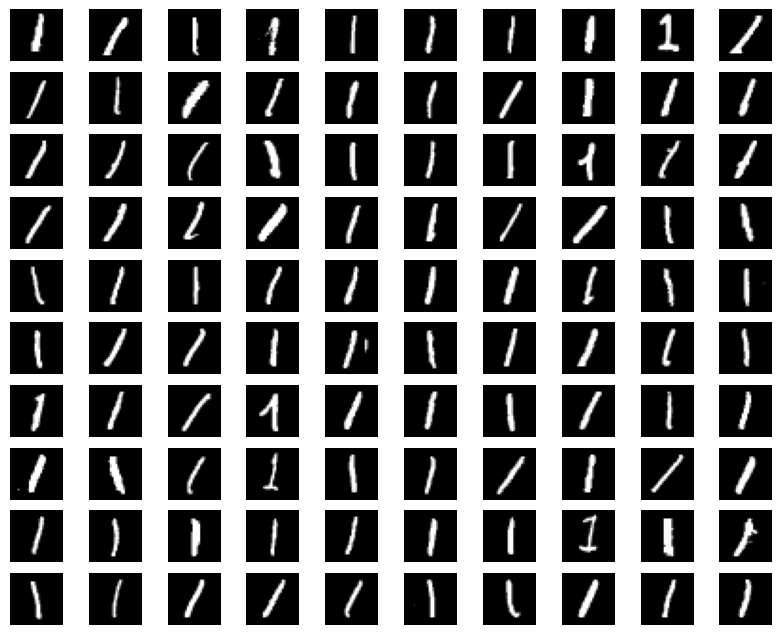

In [54]:
figure = plt.figure(figsize=(10, 8))
n = 10
cols, rows = n, n

for x in range(1, n**2 + 1):
    label = 0
    while label != 1:
        image, label = trainDataset[torch.randint(0,len(trainDataset), (1,)).item()]

    figure.add_subplot(cols,rows, x)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    


plt.show()

In [71]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(testDataset), size=(1,)).item()
    if testDataset[i][1] == 1:
        print(testDataset[i][1])
    # img, label = testDataset[sample_idx]
    # figure.add_subplot(rows, cols, i)
    # plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

1
1
1


<Figure size 1000x800 with 0 Axes>

CNN Model

In [35]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet,self).__init__()
        
        # LeNet Architecture
        
        # First Block
        self.convBlock1 = nn.Conv2d(channels, 20, (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2), (2,2))

        # Second Block
        self.convBlock2 = nn.Conv2d(20,50, (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2), (2,2))

        # Fully Connected Layer
        self.fullyConnected1 = nn.Linear(800,500)
        self.relu3 = nn.ReLU()

        # Softmax for logit to predictions
        self.fullyConnected2 = nn.Linear(500,classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        # First Block Pass
        x = self.maxpool1(self.relu1(self.convBlock1(x)))
        
        # Second Block Pass
        x = self.maxpool2(self.relu2(self.convBlock2(x)))
        
        # Flatten and pass to Fully Connected Layer
        x = self.relu3(self.fullyConnected1(torch.flatten(x,1)))

        # Softmax Pass
        x = self.fullyConnected2(x)
        output = self.logSoftmax(x)

        return output


Not mine below

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders



import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    

cnn = CNN()

loss_func = nn.CrossEntropyLoss()   
loss_func

optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [5]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.2197
Epoch [1/10], Step [200/600], Loss: 0.2352
Epoch [1/10], Step [300/600], Loss: 0.0476
Epoch [1/10], Step [400/600], Loss: 0.0259
Epoch [1/10], Step [500/600], Loss: 0.1180
Epoch [1/10], Step [600/600], Loss: 0.2497
Epoch [2/10], Step [100/600], Loss: 0.1350
Epoch [2/10], Step [200/600], Loss: 0.0731
Epoch [2/10], Step [300/600], Loss: 0.0278
Epoch [2/10], Step [400/600], Loss: 0.0981
Epoch [2/10], Step [500/600], Loss: 0.0916
Epoch [2/10], Step [600/600], Loss: 0.0817
Epoch [3/10], Step [100/600], Loss: 0.0880
Epoch [3/10], Step [200/600], Loss: 0.1753
Epoch [3/10], Step [300/600], Loss: 0.0088
Epoch [3/10], Step [400/600], Loss: 0.0478
Epoch [3/10], Step [500/600], Loss: 0.0531
Epoch [3/10], Step [600/600], Loss: 0.0361
Epoch [4/10], Step [100/600], Loss: 0.0235
Epoch [4/10], Step [200/600], Loss: 0.0515
Epoch [4/10], Step [300/600], Loss: 0.1233
Epoch [4/10], Step [400/600], Loss: 0.0062
Epoch [4/10], Step [500/600], Loss: 0.0224
Epoch [4/10

In [7]:
# cnn.to(device)
cnn.to("cpu")

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [136]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load and preprocess the image
image_path = 'USERDIGIT.png'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])
preprocessed_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Instantiate the model
# model = CNN()

# Pass the preprocessed image through the model
output, x = cnn(preprocessed_image)

# Apply softmax to the output
softmax = nn.Softmax(dim=1)
probabilities = softmax(output)

# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=1)

# Print the predicted class
print(predicted_class.item())

2


TypeError: Invalid shape (100,) for image data

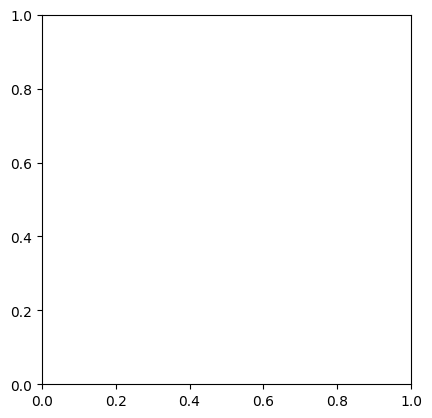

In [45]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            plt.imshow(torch.max(test_output,1)[1])
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass

test()

In [34]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms
from torchvision.transforms import Resize, ToTensor, Grayscale

x = Image.open("USERDIGIT.png")

desiredSize = (32, 49)

transform = transforms.Compose([
    Resize(desiredSize),
    ToTensor(),
])

image = transform(x)
# image.unsqueeze(0).shape

# torch.argmax(cnn(image.unsqueeze(0)))
# test, last = cnn(image)
cnn(image)


# Transform
# transform = transforms.Compose([
    # Resize(desiredSize),
    # transforms.Grayscale(),
    # ToTensor(),
# ])
# transformed_image = transform(image)


# print(transformed_image.shape)

# a = transformed_image.numpy()
# a = a.transpose(1,2,0)
# plt.imshow(a, cmap="gray")
# plt.axis("off")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x96 and 1568x10)

In [105]:
for x,y in loaders['train']:
    print(x)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

TypeError: max(): argument 'input' (position 1) must be Tensor, not tuple

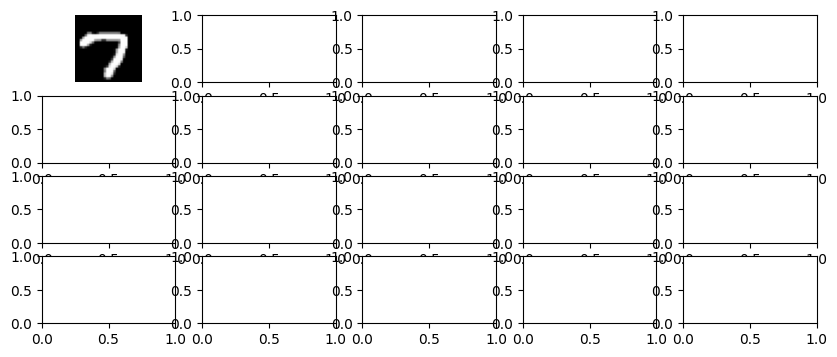

In [88]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    cnn.eval()
    with torch.inference_mode():
        prediction = cnn(image.unsqueeze(0).to("cpu"))


    # predicted_class = torch.argmax(prediction).item()
    predicted_class = torch.max(prediction).item()
    # print("Ground truth label:", label)
    # print(f"Predicted Digit: {predicted_class}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Train Init

In [ ]:
# HYPERPARAMETERS
lr = 1e-3
lr = 1e-6
# lr = 0.01
BATCH_SIZE = 32
epochs = 100

# Split data
trainSplit = 0.8
valSplit = 1-trainSplit

trainSamples = int(len(trainDataset) * trainSplit)
valSamples = int(round(len(trainDataset) * valSplit,0))

(trainData, valData) = random_split(trainDataset, [trainSamples, valSamples], generator=torch.Generator().manual_seed(42))

In [ ]:
# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE)


# Batches
trainBatches = len(trainLoader.dataset) // BATCH_SIZE
valBatches = len(valLoader.dataset) // BATCH_SIZE

In [ ]:
# Init

model = LeNet(1,len(trainData.dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lossFn = nn.NLLLoss()

modelRes = {
    "train_loss" : [],
    "train_acc" : [],
    "val_loss" : [],
    "val_acc" : []
}

# Timing
startTime = time.time()

Training and Testing Loop

In [ ]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    
    model.train()

     # Create inner tqdm progress bar for batches
    train_batch_progress = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0


    # Forward Pass
    for (x,y) in train_batch_progress:
        (x,y) = (x.to(device),y.to(device))

        # Loss
        pred = model(x)
        loss = lossFn(pred, y)
    
        # Optimizer Zero Grad
        optimizer.zero_grad()
    
        # Loss Backward
        loss.backward()

        # Optimizer Step 
        optimizer.step()

        totalTrainLoss += loss.item()
        totalTrainLoss = loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
    
    model.eval()
    with torch.inference_mode():
        for (xVal, yVal) in valLoader:
            (xVal, yVal) = (xVal.to(device), yVal.to(device))

            # Forward Pass
            valPred = model(xVal)

            # Loss
            valLoss = lossFn(valPred, yVal)
            totalValLoss += valLoss.item()
            totalValLoss = valLoss

            valCorrect += (valPred.argmax(1) == yVal).type(torch.float).sum().item() 

    print(f'Train Loss: {totalTrainLoss} | Val Loss: {totalValLoss} | Val Correct: {valCorrect}')

        



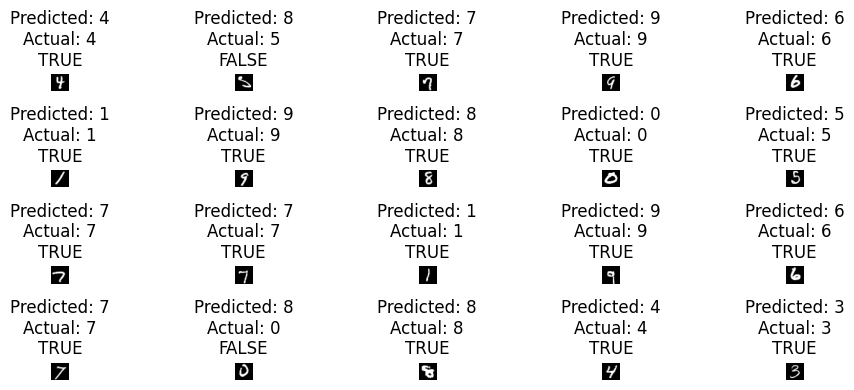

In [82]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    model.eval()
    with torch.inference_mode():
        prediction = model(image.unsqueeze(0).to(device))


    predicted_class = torch.argmax(prediction).item()
    # print("Ground truth label:", label)
    # print(f"Predicted Digit: {predicted_class}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Save Model

In [114]:
# Save Model
import os

baseName = "HDR.pth"
i = 1
fileName = baseName

while os.path.exists(fileName):
    fileName = f"{os.path.splitext(baseName)[0]}_{i}.pth"
    i += 1

torch.save(model.state_dict(), fileName)

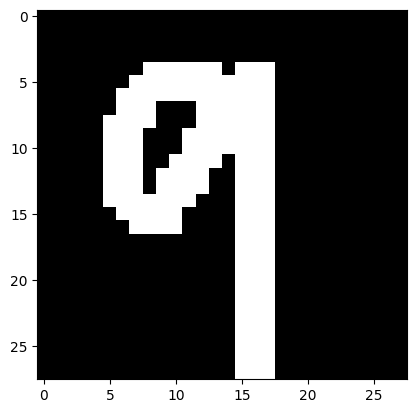

In [116]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms
from torchvision.transforms import Resize, ToTensor, Grayscale

x = ""
# x = x.split(",")[1]
# print(x)


x = base64.b64decode(x)
image_array = np.frombuffer(x, np.uint8)
image = plt.imread(BytesIO(image_array))

# plt.imshow(image)
# plt.axis("off")

x = ""

x = base64.b64decode(x)
image = Image.open(BytesIO(x))
desiredSize = (28,28)

# Transform
transform = transforms.Compose([
    Resize(desiredSize),
    transforms.Grayscale(),
    ToTensor(),
])
transformed_image = transform(image)


print(transformed_image.shape)

a = transformed_image.numpy()
a = a.transpose(1,2,0)
plt.imshow(a, cmap="gray")
plt.axis("off")

In [81]:
model = LeNet(1,10)
state_dict = torch.load("HDR.pth", torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)

In [106]:
# model(transformed_image.squeeze())
# torch.argmax(model(image.unsqueeze(0).to(device))).item()
# torch.argmax(model(transformed_image.unsqueeze(0).to(device))).item()
torch.argmax(cnn(transformed_image.unsqueeze(0).to(device))).item()


NameError: name 'transformed_image' is not defined